## Convolutional Autoencoder

In this notebook, we will be implementing a simple Autoencoder for images. Autoencoders are a type of neural networks that learn the features from the data by compressing the data and then reproducing the output same as input. 

### Architecture:

***Input Data  =>  Encoder  => Hidden Layer  =>   Decoder  =>  Output Data***

Note that the Input Data == Output Data.

The number of nerons in the Input Layer i.e. Encoder == number of neurons in Output Layer i.e. Decoder.

The hidden layer is where the magic happens. The hidden layer may have the number of neurons that might be less than the Output Layer (i.e. "Undercomplete Autoencoder") or if the number of neurons are more in the Hidden layer than the Output Layer (i.e. "Overcomplete Autoencoder").

The Encoder for a Convolutional Autoencoder uses Convolution layers instead of the Fully Connected Layers as in the linear Autoencoder followed by MaxPooling layer. 

At the Hidden Layer, the model takes in the data from a higher dimension and compresses it into lower dimension by learning features from the Input Data.

Once the features are learnt, the data moves to the Decoder part which uses Transposed Convolutions along with Maxpooling to get the final image equal to the size of the Input Image. Sometimes, during the decoding process, the image gets blurry or appears in form of blocks. So, to avoid that, we use Upsampling.

In [1]:
# Import Dependencies
import numpy as np
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Load Dataset
fashion_mnist = input_data.read_data_sets('./dataset/fashion-MNIST/', one_hot=True)

Extracting ./dataset/fashion-MNIST/train-images-idx3-ubyte.gz
Extracting ./dataset/fashion-MNIST/train-labels-idx1-ubyte.gz
Extracting ./dataset/fashion-MNIST/t10k-images-idx3-ubyte.gz
Extracting ./dataset/fashion-MNIST/t10k-labels-idx1-ubyte.gz


In [3]:
# Shapes of training set
print("Training set (images) shape: ",fashion_mnist.train.images.shape)
print("Training set (labels) shape: ",fashion_mnist.train.labels.shape)

# Shapes of test set
print("Test set (images) shape: ", fashion_mnist.test.images.shape)
print("Test set (labels) shape: ", fashion_mnist.test.labels.shape)

Training set (images) shape:  (55000, 784)
Training set (labels) shape:  (55000, 10)
Test set (images) shape:  (10000, 784)
Test set (labels) shape:  (10000, 10)


In [4]:
# Create a list of what each label means
label_names = ['T-Shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']

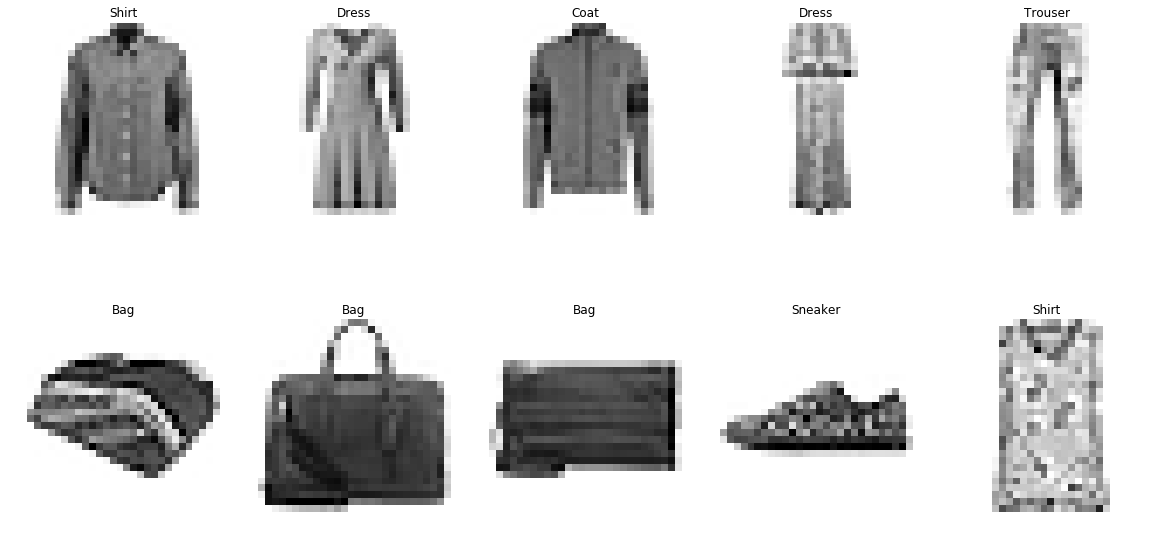

In [5]:
# Plot Random Image
n = np.random.randint(0,55000,10)
names = []

# Get the Index for Label_Names array and append names to array []
with tf.Session() as sess:
    for i in range(len(n)):
        l = tf.argmax(fashion_mnist.train.labels[n][i], axis=0)
        names.append(label_names[sess.run(l)])
sess.close()

# Plot Images
fig, ax = plt.subplots(nrows=2,ncols=5, figsize=(20,10))
u = 0
for i in range(2):
    for j in range(5):
        ax[i,j].imshow(fashion_mnist.train.images[n][u].reshape(28,28), cmap='Greys')
        ax[i,j].set_axis_off()
        ax[i,j].set_title(names[u])
        u += 1

In [6]:
# Helper Function to Plot Images
def plot_images(out_img=None):
    fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
    test_imgs = fashion_mnist.test.images[:10]
    
    for images, row in zip([test_imgs, out_img], axes):
        for img, ax in zip(images, row):
            ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    fig.tight_layout(pad=0.1)
    plt.show()

### Autoencoder Modle

In [7]:
# Define Constants
# Learning Rate
lr = 0.001

In [8]:
# Define Placeholders
# Input Image
input_image = tf.placeholder(tf.float32,shape=[None,28,28,1], name="input_image")

# Target Image / Reproduced Image
target_image = tf.placeholder(tf.float32,shape=[None,28,28,1], name="output_image")

### Encoder

In [9]:
# Encoder Module
with tf.name_scope('Encoder'):
    # First Convolutional layer
    conv1 = tf.layers.conv2d(inputs=input_image, filters= 32, kernel_size= (3,3), padding= 'same', activation= tf.nn.relu, name='Conv1')
    # Max Pooling 1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=(2,2), strides=(2,2), padding= 'same', name='Pool1')
    # Second Convolutional layer
    conv2 = tf.layers.conv2d(inputs=pool1, filters= 16, kernel_size= (3,3), padding= 'same', activation= tf.nn.relu, name='Conv2')
    # Max Pooling 2
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=(2,2), strides=(2,2), padding= 'same', name='Pool2')
    # Third Convolutional layer
    conv3 = tf.layers.conv2d(inputs=pool2, filters= 8, kernel_size= (3,3), padding= 'same', activation= tf.nn.relu, name='Conv3')
    # Max Pooling 3
    encoded_image = tf.layers.max_pooling2d(inputs=conv3, pool_size=(2,2), strides=(2,2), padding= 'same', name='Encoded_Image')

### Decoder

For the decoder we have two options:

**1. Use Transposed Convolutions:**

This works in opposite way as compared to a convolution process and gets us the original image size output. The drawback of using thi sapproach is that in the output image generated, we may see some checkblocks. Hence, the image is not as clear as expected.

**2. Resize using UpSampling and use Convolutions:**

Using this approach has proven to be better as compared to the first approach as using this we can get much better images at the output.

In [10]:
# Decoder Module
# Input = encoded_image
with tf.name_scope('Decoder'):
    # Upsampling Image to get Better Quality Image at Output
    #upsample_image1 = tf.image.resize_images(images=encoded_image, size=(7,7), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # First Convolution Layer
    deconv1 = tf.layers.conv2d(inputs=encoded_image, filters= 8, kernel_size=(3,3), padding= 'same', activation= tf.nn.relu, name='De-Conv1')
    # Upsampling Image to get Better Quality Image at Output
    upsample_image2 = tf.image.resize_images(images=deconv1, size=(14,14), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # First Convolution Layer
    deconv2 = tf.layers.conv2d(inputs=upsample_image2, filters= 16, kernel_size=(3,3), padding= 'same', activation= tf.nn.relu, name='De-Conv2')
    # Upsampling Image to get Better Quality Image at Output
    upsample_image3 = tf.image.resize_images(images=deconv2, size=(28,28), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    # First Convolution Layer
    deconv3 = tf.layers.conv2d(inputs=upsample_image3, filters= 32, kernel_size=(3,3), padding= 'same', activation= tf.nn.relu, name='De-Conv3')
    # Test Dropout
    #dropout = tf.layers.dropout(inputs=deconv3, rate=0.4)
    logits = tf.layers.conv2d(inputs=deconv3, filters=1, kernel_size=(3,3), padding='same', activation=None, name='logits')
    # Pass logits through sigmoid to get reconstructed image
    decoded_image = tf.nn.sigmoid(logits, name='Decoded_Image')

In [11]:
# Cost Function:Cross Entropy With Logits
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=target_image, logits=logits))

# Optimizer
optimizer = tf.train.AdamOptimizer(lr).minimize(cost)

# Define a Model Saver
save_model = tf.train.Saver()

# Test Images
test_images = fashion_mnist.test.images[:10]

In [12]:
# Initialize all Variables
init = tf.global_variables_initializer()

Epoch: 0/20	 Training Loss: 0.6939
Epoch: 0/20	 Training Loss: 0.6919
Epoch: 0/20	 Training Loss: 0.6903
Epoch: 0/20	 Training Loss: 0.6877
Epoch: 0/20	 Training Loss: 0.6841
Epoch: 0/20	 Training Loss: 0.6805
Epoch: 0/20	 Training Loss: 0.6761
Epoch: 0/20	 Training Loss: 0.6687
Epoch: 0/20	 Training Loss: 0.6640
Epoch: 0/20	 Training Loss: 0.6516
Epoch: 0/20	 Training Loss: 0.6447
Epoch: 0/20	 Training Loss: 0.6386
Epoch: 0/20	 Training Loss: 0.6380
Epoch: 0/20	 Training Loss: 0.6118
Epoch: 0/20	 Training Loss: 0.6196
Epoch: 0/20	 Training Loss: 0.6175
Epoch: 0/20	 Training Loss: 0.6097
Epoch: 0/20	 Training Loss: 0.5982
Epoch: 0/20	 Training Loss: 0.5664
Epoch: 0/20	 Training Loss: 0.5484
Epoch: 0/20	 Training Loss: 0.5510
Epoch: 0/20	 Training Loss: 0.5404
Epoch: 0/20	 Training Loss: 0.5054
Epoch: 0/20	 Training Loss: 0.5088
Epoch: 0/20	 Training Loss: 0.5012
Epoch: 0/20	 Training Loss: 0.4854
Epoch: 0/20	 Training Loss: 0.4761
Epoch: 0/20	 Training Loss: 0.4571
Epoch: 0/20	 Trainin

Epoch: 0/20	 Training Loss: 0.3083
Epoch: 0/20	 Training Loss: 0.3062
Epoch: 0/20	 Training Loss: 0.3055
Epoch: 0/20	 Training Loss: 0.3217
Epoch: 0/20	 Training Loss: 0.3065
Epoch: 0/20	 Training Loss: 0.3050
Epoch: 0/20	 Training Loss: 0.3029
Epoch: 0/20	 Training Loss: 0.3112
Epoch: 0/20	 Training Loss: 0.3153
Epoch: 0/20	 Training Loss: 0.3015
Epoch: 0/20	 Training Loss: 0.3105
Epoch: 0/20	 Training Loss: 0.3212
Epoch: 0/20	 Training Loss: 0.3147
Epoch: 0/20	 Training Loss: 0.3186
Epoch: 0/20	 Training Loss: 0.3049
Epoch: 0/20	 Training Loss: 0.3055
Epoch: 0/20	 Training Loss: 0.3056
Epoch: 0/20	 Training Loss: 0.3094
Epoch: 0/20	 Training Loss: 0.3125
Epoch: 0/20	 Training Loss: 0.3174
Epoch: 0/20	 Training Loss: 0.3083
Epoch: 0/20	 Training Loss: 0.2952
Epoch: 0/20	 Training Loss: 0.3123
Epoch: 0/20	 Training Loss: 0.3103
Epoch: 0/20	 Training Loss: 0.3064
Epoch: 0/20	 Training Loss: 0.3063
Epoch: 0/20	 Training Loss: 0.3040
Epoch: 0/20	 Training Loss: 0.3091
Epoch: 0/20	 Trainin

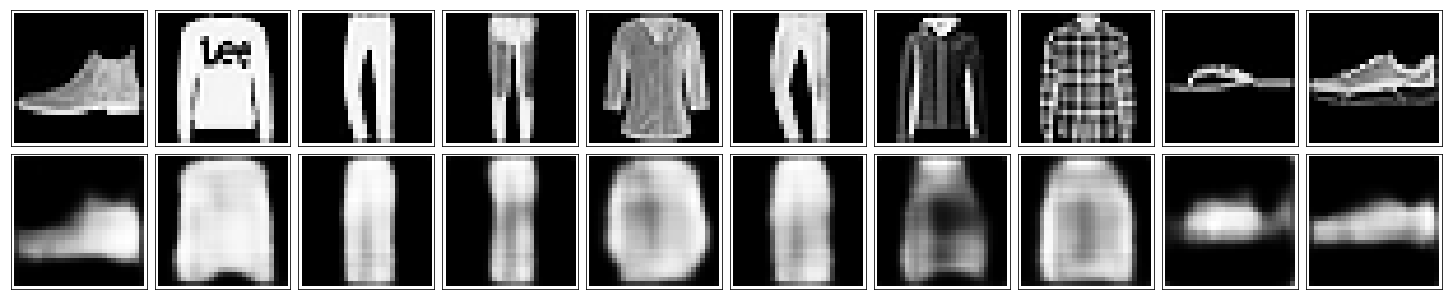

Epoch: 1/20	 Training Loss: 0.3009
Epoch: 1/20	 Training Loss: 0.3144
Epoch: 1/20	 Training Loss: 0.3060
Epoch: 1/20	 Training Loss: 0.3028
Epoch: 1/20	 Training Loss: 0.3056
Epoch: 1/20	 Training Loss: 0.3119
Epoch: 1/20	 Training Loss: 0.3048
Epoch: 1/20	 Training Loss: 0.3189
Epoch: 1/20	 Training Loss: 0.3109
Epoch: 1/20	 Training Loss: 0.3167
Epoch: 1/20	 Training Loss: 0.3063
Epoch: 1/20	 Training Loss: 0.3099
Epoch: 1/20	 Training Loss: 0.3034
Epoch: 1/20	 Training Loss: 0.3085
Epoch: 1/20	 Training Loss: 0.3063
Epoch: 1/20	 Training Loss: 0.3021
Epoch: 1/20	 Training Loss: 0.3110
Epoch: 1/20	 Training Loss: 0.2979
Epoch: 1/20	 Training Loss: 0.2986
Epoch: 1/20	 Training Loss: 0.2959
Epoch: 1/20	 Training Loss: 0.3143
Epoch: 1/20	 Training Loss: 0.3144
Epoch: 1/20	 Training Loss: 0.3013
Epoch: 1/20	 Training Loss: 0.3010
Epoch: 1/20	 Training Loss: 0.3105
Epoch: 1/20	 Training Loss: 0.2975
Epoch: 1/20	 Training Loss: 0.3109
Epoch: 1/20	 Training Loss: 0.3128
Epoch: 1/20	 Trainin

Epoch: 1/20	 Training Loss: 0.3112
Epoch: 1/20	 Training Loss: 0.3029
Epoch: 1/20	 Training Loss: 0.2920
Epoch: 1/20	 Training Loss: 0.2981
Epoch: 1/20	 Training Loss: 0.2983
Epoch: 1/20	 Training Loss: 0.3002
Epoch: 1/20	 Training Loss: 0.3054
Epoch: 1/20	 Training Loss: 0.2946
Epoch: 1/20	 Training Loss: 0.2972
Epoch: 1/20	 Training Loss: 0.3002
Epoch: 1/20	 Training Loss: 0.3035
Epoch: 1/20	 Training Loss: 0.2989
Epoch: 1/20	 Training Loss: 0.2990
Epoch: 1/20	 Training Loss: 0.3087
Epoch: 1/20	 Training Loss: 0.2919
Epoch: 1/20	 Training Loss: 0.2905
Epoch: 1/20	 Training Loss: 0.3068
Epoch: 1/20	 Training Loss: 0.2975
Epoch: 1/20	 Training Loss: 0.2995
Epoch: 1/20	 Training Loss: 0.2964
Epoch: 1/20	 Training Loss: 0.2999
Epoch: 1/20	 Training Loss: 0.2934
Epoch: 1/20	 Training Loss: 0.3003
Epoch: 1/20	 Training Loss: 0.2910
Epoch: 1/20	 Training Loss: 0.3048
Epoch: 1/20	 Training Loss: 0.3036
Epoch: 1/20	 Training Loss: 0.2970
Epoch: 1/20	 Training Loss: 0.3119
Epoch: 1/20	 Trainin

Epoch: 2/20	 Training Loss: 0.2935
Epoch: 2/20	 Training Loss: 0.2947
Epoch: 2/20	 Training Loss: 0.3009
Epoch: 2/20	 Training Loss: 0.2934
Epoch: 2/20	 Training Loss: 0.2937
Epoch: 2/20	 Training Loss: 0.2932
Epoch: 2/20	 Training Loss: 0.2948
Epoch: 2/20	 Training Loss: 0.2955
Epoch: 2/20	 Training Loss: 0.2947
Epoch: 2/20	 Training Loss: 0.2883
Epoch: 2/20	 Training Loss: 0.2992
Epoch: 2/20	 Training Loss: 0.3041
Epoch: 2/20	 Training Loss: 0.2996
Epoch: 2/20	 Training Loss: 0.3013
Epoch: 2/20	 Training Loss: 0.2888
Epoch: 2/20	 Training Loss: 0.2985
Epoch: 2/20	 Training Loss: 0.2907
Epoch: 2/20	 Training Loss: 0.2789
Epoch: 2/20	 Training Loss: 0.2857
Epoch: 2/20	 Training Loss: 0.2995
Epoch: 2/20	 Training Loss: 0.2965
Epoch: 2/20	 Training Loss: 0.2900
Epoch: 2/20	 Training Loss: 0.2938
Epoch: 2/20	 Training Loss: 0.2925
Epoch: 2/20	 Training Loss: 0.2914
Epoch: 2/20	 Training Loss: 0.2991
Epoch: 2/20	 Training Loss: 0.3003
Epoch: 2/20	 Training Loss: 0.2945
Epoch: 2/20	 Trainin

Epoch: 3/20	 Training Loss: 0.2941
Epoch: 3/20	 Training Loss: 0.2960
Epoch: 3/20	 Training Loss: 0.2864
Epoch: 3/20	 Training Loss: 0.3054
Epoch: 3/20	 Training Loss: 0.2910
Epoch: 3/20	 Training Loss: 0.2971
Epoch: 3/20	 Training Loss: 0.3097
Epoch: 3/20	 Training Loss: 0.2907
Epoch: 3/20	 Training Loss: 0.3021
Epoch: 3/20	 Training Loss: 0.2922
Epoch: 3/20	 Training Loss: 0.2927
Epoch: 3/20	 Training Loss: 0.3014
Epoch: 3/20	 Training Loss: 0.2988
Epoch: 3/20	 Training Loss: 0.2896
Epoch: 3/20	 Training Loss: 0.2989
Epoch: 3/20	 Training Loss: 0.2970
Epoch: 3/20	 Training Loss: 0.2962
Epoch: 3/20	 Training Loss: 0.2908
Epoch: 3/20	 Training Loss: 0.2861
Epoch: 3/20	 Training Loss: 0.2913
Epoch: 3/20	 Training Loss: 0.2927
Epoch: 3/20	 Training Loss: 0.2897
Epoch: 3/20	 Training Loss: 0.2909
Epoch: 3/20	 Training Loss: 0.2843
Epoch: 3/20	 Training Loss: 0.2815
Epoch: 3/20	 Training Loss: 0.2886
Epoch: 3/20	 Training Loss: 0.2950
Epoch: 3/20	 Training Loss: 0.2919
Epoch: 3/20	 Trainin

Epoch: 4/20	 Training Loss: 0.2887
Epoch: 4/20	 Training Loss: 0.2886
Epoch: 4/20	 Training Loss: 0.2830
Epoch: 4/20	 Training Loss: 0.2888
Epoch: 4/20	 Training Loss: 0.2921
Epoch: 4/20	 Training Loss: 0.2963
Epoch: 4/20	 Training Loss: 0.2939
Epoch: 4/20	 Training Loss: 0.2856
Epoch: 4/20	 Training Loss: 0.2869
Epoch: 4/20	 Training Loss: 0.2910
Epoch: 4/20	 Training Loss: 0.2983
Epoch: 4/20	 Training Loss: 0.2981
Epoch: 4/20	 Training Loss: 0.2938
Epoch: 4/20	 Training Loss: 0.2849
Epoch: 4/20	 Training Loss: 0.2785
Epoch: 4/20	 Training Loss: 0.2782
Epoch: 4/20	 Training Loss: 0.2958
Epoch: 4/20	 Training Loss: 0.2853
Epoch: 4/20	 Training Loss: 0.2917
Epoch: 4/20	 Training Loss: 0.2947
Epoch: 4/20	 Training Loss: 0.2903
Epoch: 4/20	 Training Loss: 0.3045
Epoch: 4/20	 Training Loss: 0.2875
Epoch: 4/20	 Training Loss: 0.2908
Epoch: 4/20	 Training Loss: 0.2910
Epoch: 4/20	 Training Loss: 0.2883
Epoch: 4/20	 Training Loss: 0.2910
Epoch: 4/20	 Training Loss: 0.3005
Epoch: 4/20	 Trainin

Epoch: 5/20	 Training Loss: 0.2868
Epoch: 5/20	 Training Loss: 0.2855
Epoch: 5/20	 Training Loss: 0.2963
Epoch: 5/20	 Training Loss: 0.2962
Epoch: 5/20	 Training Loss: 0.2854
Epoch: 5/20	 Training Loss: 0.2755
Epoch: 5/20	 Training Loss: 0.2962
Epoch: 5/20	 Training Loss: 0.2851
Epoch: 5/20	 Training Loss: 0.2916
Epoch: 5/20	 Training Loss: 0.2813
Epoch: 5/20	 Training Loss: 0.2832
Epoch: 5/20	 Training Loss: 0.2830
Epoch: 5/20	 Training Loss: 0.2811
Epoch: 5/20	 Training Loss: 0.2953
Epoch: 5/20	 Training Loss: 0.2874
Epoch: 5/20	 Training Loss: 0.2911
Epoch: 5/20	 Training Loss: 0.2863
Epoch: 5/20	 Training Loss: 0.2922
Epoch: 5/20	 Training Loss: 0.2939
Epoch: 5/20	 Training Loss: 0.2935
Epoch: 5/20	 Training Loss: 0.2800
Epoch: 5/20	 Training Loss: 0.2924
Epoch: 5/20	 Training Loss: 0.2944
Epoch: 5/20	 Training Loss: 0.2921
Epoch: 5/20	 Training Loss: 0.2946
Epoch: 5/20	 Training Loss: 0.2907
Epoch: 5/20	 Training Loss: 0.2866
Epoch: 5/20	 Training Loss: 0.2877
Epoch: 5/20	 Trainin

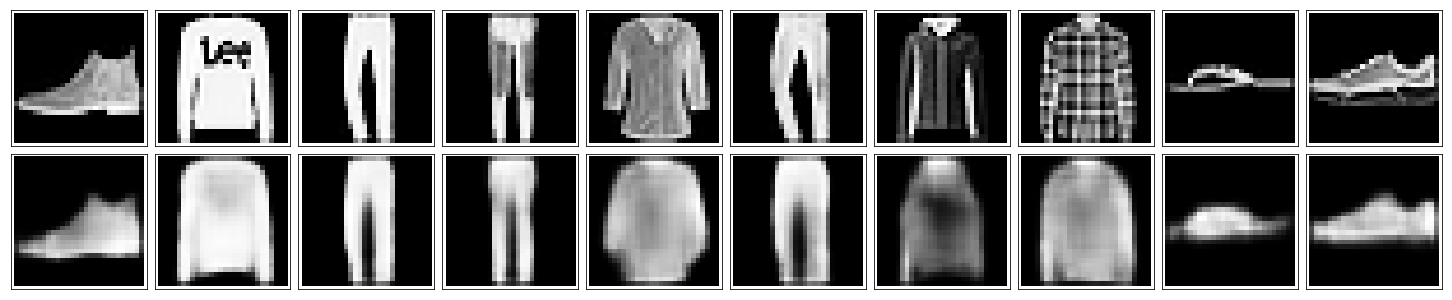

Epoch: 6/20	 Training Loss: 0.2868
Epoch: 6/20	 Training Loss: 0.2865
Epoch: 6/20	 Training Loss: 0.2936
Epoch: 6/20	 Training Loss: 0.2821
Epoch: 6/20	 Training Loss: 0.2849
Epoch: 6/20	 Training Loss: 0.2805
Epoch: 6/20	 Training Loss: 0.2934
Epoch: 6/20	 Training Loss: 0.2782
Epoch: 6/20	 Training Loss: 0.2895
Epoch: 6/20	 Training Loss: 0.2963
Epoch: 6/20	 Training Loss: 0.2998
Epoch: 6/20	 Training Loss: 0.2989
Epoch: 6/20	 Training Loss: 0.2879
Epoch: 6/20	 Training Loss: 0.2787
Epoch: 6/20	 Training Loss: 0.2863
Epoch: 6/20	 Training Loss: 0.2882
Epoch: 6/20	 Training Loss: 0.2915
Epoch: 6/20	 Training Loss: 0.3015
Epoch: 6/20	 Training Loss: 0.2945
Epoch: 6/20	 Training Loss: 0.2988
Epoch: 6/20	 Training Loss: 0.2922
Epoch: 6/20	 Training Loss: 0.2769
Epoch: 6/20	 Training Loss: 0.2819
Epoch: 6/20	 Training Loss: 0.2988
Epoch: 6/20	 Training Loss: 0.2778
Epoch: 6/20	 Training Loss: 0.2783
Epoch: 6/20	 Training Loss: 0.2902
Epoch: 6/20	 Training Loss: 0.2806
Epoch: 6/20	 Trainin

Epoch: 6/20	 Training Loss: 0.2833
Epoch: 6/20	 Training Loss: 0.2775
Epoch: 6/20	 Training Loss: 0.2880
Epoch: 6/20	 Training Loss: 0.2867
Epoch: 6/20	 Training Loss: 0.2915
Epoch: 6/20	 Training Loss: 0.2820
Epoch: 6/20	 Training Loss: 0.2773
Epoch: 6/20	 Training Loss: 0.2830
Epoch: 6/20	 Training Loss: 0.2917
Epoch: 6/20	 Training Loss: 0.2847
Epoch: 6/20	 Training Loss: 0.2861
Epoch: 6/20	 Training Loss: 0.2886
Epoch: 6/20	 Training Loss: 0.2929
Epoch: 6/20	 Training Loss: 0.2870
Epoch: 6/20	 Training Loss: 0.3003
Epoch: 6/20	 Training Loss: 0.2887
Epoch: 6/20	 Training Loss: 0.2872
Epoch: 6/20	 Training Loss: 0.2866
Epoch: 6/20	 Training Loss: 0.2781
Epoch: 6/20	 Training Loss: 0.2874
Epoch: 6/20	 Training Loss: 0.2905
Epoch: 6/20	 Training Loss: 0.2801
Epoch: 6/20	 Training Loss: 0.2894
Epoch: 6/20	 Training Loss: 0.2953
Epoch: 6/20	 Training Loss: 0.2817
Epoch: 6/20	 Training Loss: 0.2827
Epoch: 6/20	 Training Loss: 0.2909
Epoch: 6/20	 Training Loss: 0.2807
Epoch: 6/20	 Trainin

Epoch: 7/20	 Training Loss: 0.2847
Epoch: 7/20	 Training Loss: 0.2839
Epoch: 7/20	 Training Loss: 0.2808
Epoch: 7/20	 Training Loss: 0.2908
Epoch: 7/20	 Training Loss: 0.2832
Epoch: 7/20	 Training Loss: 0.2780
Epoch: 7/20	 Training Loss: 0.2896
Epoch: 7/20	 Training Loss: 0.2860
Epoch: 7/20	 Training Loss: 0.2856
Epoch: 7/20	 Training Loss: 0.2884
Epoch: 7/20	 Training Loss: 0.2839
Epoch: 7/20	 Training Loss: 0.2901
Epoch: 7/20	 Training Loss: 0.2862
Epoch: 7/20	 Training Loss: 0.2809
Epoch: 7/20	 Training Loss: 0.2837
Epoch: 7/20	 Training Loss: 0.3041
Epoch: 7/20	 Training Loss: 0.2875
Epoch: 7/20	 Training Loss: 0.2804
Epoch: 7/20	 Training Loss: 0.2927
Epoch: 7/20	 Training Loss: 0.2898
Epoch: 7/20	 Training Loss: 0.2814
Epoch: 7/20	 Training Loss: 0.2914
Epoch: 7/20	 Training Loss: 0.2766
Epoch: 7/20	 Training Loss: 0.2846
Epoch: 7/20	 Training Loss: 0.2871
Epoch: 7/20	 Training Loss: 0.2841
Epoch: 7/20	 Training Loss: 0.2841
Epoch: 7/20	 Training Loss: 0.2765
Epoch: 7/20	 Trainin

Epoch: 8/20	 Training Loss: 0.2978
Epoch: 8/20	 Training Loss: 0.2966
Epoch: 8/20	 Training Loss: 0.2922
Epoch: 8/20	 Training Loss: 0.2967
Epoch: 8/20	 Training Loss: 0.2789
Epoch: 8/20	 Training Loss: 0.2879
Epoch: 8/20	 Training Loss: 0.2839
Epoch: 8/20	 Training Loss: 0.2823
Epoch: 8/20	 Training Loss: 0.2777
Epoch: 8/20	 Training Loss: 0.2947
Epoch: 8/20	 Training Loss: 0.2883
Epoch: 8/20	 Training Loss: 0.2849
Epoch: 8/20	 Training Loss: 0.2890
Epoch: 8/20	 Training Loss: 0.2888
Epoch: 8/20	 Training Loss: 0.2924
Epoch: 8/20	 Training Loss: 0.2780
Epoch: 8/20	 Training Loss: 0.2847
Epoch: 8/20	 Training Loss: 0.2824
Epoch: 8/20	 Training Loss: 0.2970
Epoch: 8/20	 Training Loss: 0.2740
Epoch: 8/20	 Training Loss: 0.2801
Epoch: 8/20	 Training Loss: 0.2805
Epoch: 8/20	 Training Loss: 0.2787
Epoch: 8/20	 Training Loss: 0.2894
Epoch: 8/20	 Training Loss: 0.2772
Epoch: 8/20	 Training Loss: 0.2822
Epoch: 8/20	 Training Loss: 0.2778
Epoch: 8/20	 Training Loss: 0.2851
Epoch: 8/20	 Trainin

Epoch: 9/20	 Training Loss: 0.2768
Epoch: 9/20	 Training Loss: 0.2833
Epoch: 9/20	 Training Loss: 0.2957
Epoch: 9/20	 Training Loss: 0.2823
Epoch: 9/20	 Training Loss: 0.2837
Epoch: 9/20	 Training Loss: 0.2720
Epoch: 9/20	 Training Loss: 0.2816
Epoch: 9/20	 Training Loss: 0.2802
Epoch: 9/20	 Training Loss: 0.2839
Epoch: 9/20	 Training Loss: 0.2921
Epoch: 9/20	 Training Loss: 0.2840
Epoch: 9/20	 Training Loss: 0.2837
Epoch: 9/20	 Training Loss: 0.2825
Epoch: 9/20	 Training Loss: 0.2984
Epoch: 9/20	 Training Loss: 0.2826
Epoch: 9/20	 Training Loss: 0.2796
Epoch: 9/20	 Training Loss: 0.2981
Epoch: 9/20	 Training Loss: 0.2916
Epoch: 9/20	 Training Loss: 0.2880
Epoch: 9/20	 Training Loss: 0.2917
Epoch: 9/20	 Training Loss: 0.2743
Epoch: 9/20	 Training Loss: 0.2690
Epoch: 9/20	 Training Loss: 0.2974
Epoch: 9/20	 Training Loss: 0.2793
Epoch: 9/20	 Training Loss: 0.2852
Epoch: 9/20	 Training Loss: 0.2838
Epoch: 9/20	 Training Loss: 0.2793
Epoch: 9/20	 Training Loss: 0.2984
Epoch: 9/20	 Trainin

Epoch: 10/20	 Training Loss: 0.2882
Epoch: 10/20	 Training Loss: 0.2893
Epoch: 10/20	 Training Loss: 0.2798
Epoch: 10/20	 Training Loss: 0.2844
Epoch: 10/20	 Training Loss: 0.2978
Epoch: 10/20	 Training Loss: 0.2862
Epoch: 10/20	 Training Loss: 0.2742
Epoch: 10/20	 Training Loss: 0.2852
Epoch: 10/20	 Training Loss: 0.2811
Epoch: 10/20	 Training Loss: 0.2719
Epoch: 10/20	 Training Loss: 0.2907
Epoch: 10/20	 Training Loss: 0.2865
Epoch: 10/20	 Training Loss: 0.2798
Epoch: 10/20	 Training Loss: 0.2915
Epoch: 10/20	 Training Loss: 0.2811
Epoch: 10/20	 Training Loss: 0.2910
Epoch: 10/20	 Training Loss: 0.2832
Epoch: 10/20	 Training Loss: 0.2731
Epoch: 10/20	 Training Loss: 0.2991
Epoch: 10/20	 Training Loss: 0.2803
Epoch: 10/20	 Training Loss: 0.2789
Epoch: 10/20	 Training Loss: 0.2825
Epoch: 10/20	 Training Loss: 0.2830
Epoch: 10/20	 Training Loss: 0.2828
Epoch: 10/20	 Training Loss: 0.2905
Epoch: 10/20	 Training Loss: 0.2802
Epoch: 10/20	 Training Loss: 0.2892
Epoch: 10/20	 Training Loss:

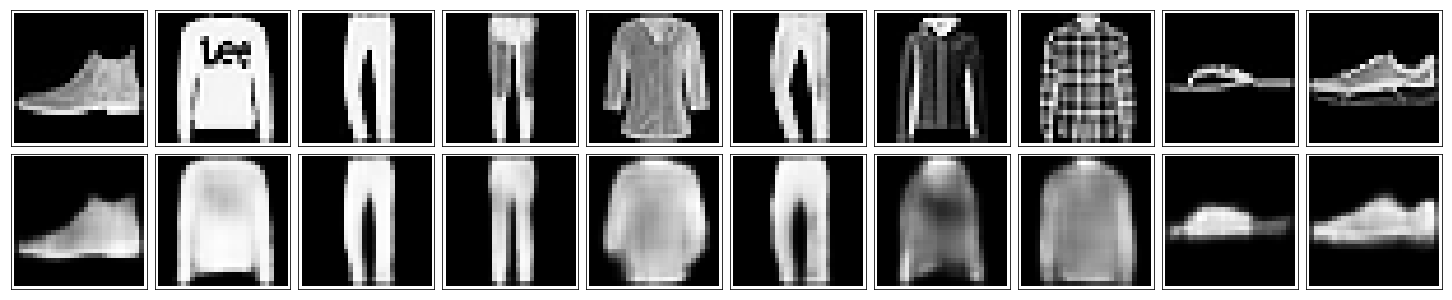

Epoch: 11/20	 Training Loss: 0.2783
Epoch: 11/20	 Training Loss: 0.2925
Epoch: 11/20	 Training Loss: 0.2853
Epoch: 11/20	 Training Loss: 0.3001
Epoch: 11/20	 Training Loss: 0.2998
Epoch: 11/20	 Training Loss: 0.2856
Epoch: 11/20	 Training Loss: 0.2801
Epoch: 11/20	 Training Loss: 0.2878
Epoch: 11/20	 Training Loss: 0.2868
Epoch: 11/20	 Training Loss: 0.2903
Epoch: 11/20	 Training Loss: 0.2861
Epoch: 11/20	 Training Loss: 0.2817
Epoch: 11/20	 Training Loss: 0.2857
Epoch: 11/20	 Training Loss: 0.2785
Epoch: 11/20	 Training Loss: 0.2801
Epoch: 11/20	 Training Loss: 0.2887
Epoch: 11/20	 Training Loss: 0.2869
Epoch: 11/20	 Training Loss: 0.2937
Epoch: 11/20	 Training Loss: 0.2846
Epoch: 11/20	 Training Loss: 0.2857
Epoch: 11/20	 Training Loss: 0.2925
Epoch: 11/20	 Training Loss: 0.2961
Epoch: 11/20	 Training Loss: 0.2960
Epoch: 11/20	 Training Loss: 0.2762
Epoch: 11/20	 Training Loss: 0.2802
Epoch: 11/20	 Training Loss: 0.2712
Epoch: 11/20	 Training Loss: 0.2775
Epoch: 11/20	 Training Loss:

Epoch: 11/20	 Training Loss: 0.2981
Epoch: 11/20	 Training Loss: 0.2933
Epoch: 11/20	 Training Loss: 0.2870
Epoch: 11/20	 Training Loss: 0.2884
Epoch: 11/20	 Training Loss: 0.2762
Epoch: 11/20	 Training Loss: 0.2806
Epoch: 11/20	 Training Loss: 0.2854
Epoch: 11/20	 Training Loss: 0.2756
Epoch: 11/20	 Training Loss: 0.2956
Epoch: 11/20	 Training Loss: 0.2932
Epoch: 11/20	 Training Loss: 0.2833
Epoch: 11/20	 Training Loss: 0.2804
Epoch: 11/20	 Training Loss: 0.2896
Epoch: 11/20	 Training Loss: 0.2913
Epoch: 11/20	 Training Loss: 0.2910
Epoch: 11/20	 Training Loss: 0.2948
Epoch: 11/20	 Training Loss: 0.2737
Epoch: 11/20	 Training Loss: 0.2840
Epoch: 11/20	 Training Loss: 0.2895
Epoch: 11/20	 Training Loss: 0.2739
Epoch: 11/20	 Training Loss: 0.2729
Epoch: 11/20	 Training Loss: 0.2907
Epoch: 11/20	 Training Loss: 0.2762
Epoch: 11/20	 Training Loss: 0.2749
Epoch: 11/20	 Training Loss: 0.2769
Epoch: 11/20	 Training Loss: 0.2721
Epoch: 11/20	 Training Loss: 0.2880
Epoch: 11/20	 Training Loss:

Epoch: 12/20	 Training Loss: 0.2861
Epoch: 12/20	 Training Loss: 0.2758
Epoch: 12/20	 Training Loss: 0.2811
Epoch: 12/20	 Training Loss: 0.2908
Epoch: 12/20	 Training Loss: 0.2750
Epoch: 12/20	 Training Loss: 0.2983
Epoch: 12/20	 Training Loss: 0.2834
Epoch: 12/20	 Training Loss: 0.2876
Epoch: 12/20	 Training Loss: 0.2948
Epoch: 12/20	 Training Loss: 0.2898
Epoch: 12/20	 Training Loss: 0.2973
Epoch: 12/20	 Training Loss: 0.2834
Epoch: 12/20	 Training Loss: 0.2855
Epoch: 12/20	 Training Loss: 0.2867
Epoch: 12/20	 Training Loss: 0.2861
Epoch: 12/20	 Training Loss: 0.2811
Epoch: 12/20	 Training Loss: 0.2779
Epoch: 12/20	 Training Loss: 0.2794
Epoch: 12/20	 Training Loss: 0.2805
Epoch: 12/20	 Training Loss: 0.2871
Epoch: 12/20	 Training Loss: 0.2836
Epoch: 12/20	 Training Loss: 0.2728
Epoch: 12/20	 Training Loss: 0.2813
Epoch: 12/20	 Training Loss: 0.2848
Epoch: 12/20	 Training Loss: 0.2844
Epoch: 12/20	 Training Loss: 0.2965
Epoch: 12/20	 Training Loss: 0.2843
Epoch: 12/20	 Training Loss:

Epoch: 13/20	 Training Loss: 0.2808
Epoch: 13/20	 Training Loss: 0.2763
Epoch: 13/20	 Training Loss: 0.2876
Epoch: 13/20	 Training Loss: 0.2810
Epoch: 13/20	 Training Loss: 0.2862
Epoch: 13/20	 Training Loss: 0.2866
Epoch: 13/20	 Training Loss: 0.2842
Epoch: 13/20	 Training Loss: 0.2758
Epoch: 13/20	 Training Loss: 0.2826
Epoch: 13/20	 Training Loss: 0.2753
Epoch: 13/20	 Training Loss: 0.2847
Epoch: 13/20	 Training Loss: 0.2810
Epoch: 13/20	 Training Loss: 0.2858
Epoch: 13/20	 Training Loss: 0.2794
Epoch: 13/20	 Training Loss: 0.2760
Epoch: 13/20	 Training Loss: 0.2849
Epoch: 13/20	 Training Loss: 0.2832
Epoch: 13/20	 Training Loss: 0.2913
Epoch: 13/20	 Training Loss: 0.2910
Epoch: 13/20	 Training Loss: 0.2729
Epoch: 13/20	 Training Loss: 0.2772
Epoch: 13/20	 Training Loss: 0.2902
Epoch: 13/20	 Training Loss: 0.2765
Epoch: 13/20	 Training Loss: 0.2800
Epoch: 13/20	 Training Loss: 0.2854
Epoch: 13/20	 Training Loss: 0.2730
Epoch: 13/20	 Training Loss: 0.2822
Epoch: 13/20	 Training Loss:

Epoch: 14/20	 Training Loss: 0.2910
Epoch: 14/20	 Training Loss: 0.2805
Epoch: 14/20	 Training Loss: 0.2792
Epoch: 14/20	 Training Loss: 0.2790
Epoch: 14/20	 Training Loss: 0.2755
Epoch: 14/20	 Training Loss: 0.2897
Epoch: 14/20	 Training Loss: 0.2807
Epoch: 14/20	 Training Loss: 0.2761
Epoch: 14/20	 Training Loss: 0.2714
Epoch: 14/20	 Training Loss: 0.2828
Epoch: 14/20	 Training Loss: 0.2853
Epoch: 14/20	 Training Loss: 0.2690
Epoch: 14/20	 Training Loss: 0.2769
Epoch: 14/20	 Training Loss: 0.2889
Epoch: 14/20	 Training Loss: 0.2857
Epoch: 14/20	 Training Loss: 0.2873
Epoch: 14/20	 Training Loss: 0.2756
Epoch: 14/20	 Training Loss: 0.2794
Epoch: 14/20	 Training Loss: 0.2610
Epoch: 14/20	 Training Loss: 0.2830
Epoch: 14/20	 Training Loss: 0.2773
Epoch: 14/20	 Training Loss: 0.2719
Epoch: 14/20	 Training Loss: 0.2852
Epoch: 14/20	 Training Loss: 0.2887
Epoch: 14/20	 Training Loss: 0.2921
Epoch: 14/20	 Training Loss: 0.2765
Epoch: 14/20	 Training Loss: 0.2886
Epoch: 14/20	 Training Loss:

Epoch: 15/20	 Training Loss: 0.2730
Epoch: 15/20	 Training Loss: 0.2833
Epoch: 15/20	 Training Loss: 0.2790
Epoch: 15/20	 Training Loss: 0.2883
Epoch: 15/20	 Training Loss: 0.2866
Epoch: 15/20	 Training Loss: 0.2787
Epoch: 15/20	 Training Loss: 0.2813
Epoch: 15/20	 Training Loss: 0.2864
Epoch: 15/20	 Training Loss: 0.2850
Epoch: 15/20	 Training Loss: 0.2847
Epoch: 15/20	 Training Loss: 0.2764
Epoch: 15/20	 Training Loss: 0.2832
Epoch: 15/20	 Training Loss: 0.2854
Epoch: 15/20	 Training Loss: 0.2768
Epoch: 15/20	 Training Loss: 0.2854
Epoch: 15/20	 Training Loss: 0.2700
Epoch: 15/20	 Training Loss: 0.2823
Epoch: 15/20	 Training Loss: 0.2723
Epoch: 15/20	 Training Loss: 0.2800
Epoch: 15/20	 Training Loss: 0.2791
Epoch: 15/20	 Training Loss: 0.2791
Epoch: 15/20	 Training Loss: 0.2901
Epoch: 15/20	 Training Loss: 0.2742
Epoch: 15/20	 Training Loss: 0.2837
Epoch: 15/20	 Training Loss: 0.2848
Epoch: 15/20	 Training Loss: 0.2929
Epoch: 15/20	 Training Loss: 0.2880
Epoch: 15/20	 Training Loss:

Epoch: 15/20	 Training Loss: 0.2780
Epoch: 15/20	 Training Loss: 0.2865
Epoch: 15/20	 Training Loss: 0.2720
Epoch: 15/20	 Training Loss: 0.2778
Epoch: 15/20	 Training Loss: 0.2774
Epoch: 15/20	 Training Loss: 0.2835
Epoch: 15/20	 Training Loss: 0.2894


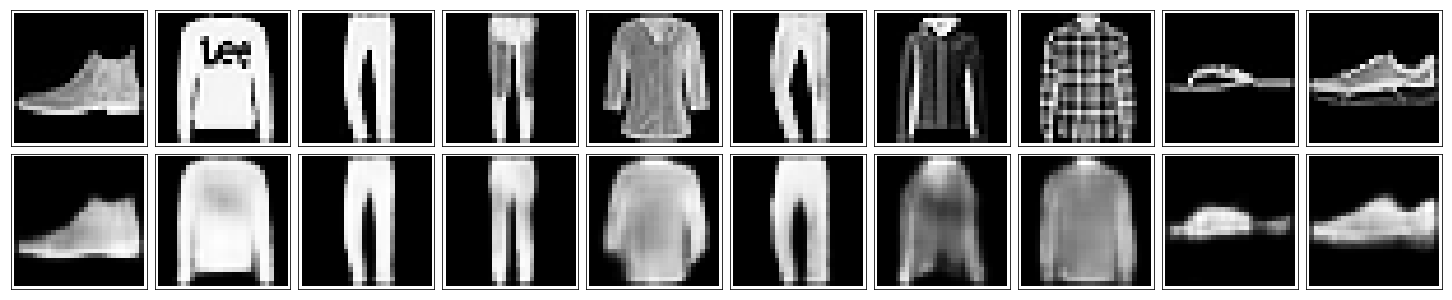

Epoch: 16/20	 Training Loss: 0.2740
Epoch: 16/20	 Training Loss: 0.2877
Epoch: 16/20	 Training Loss: 0.2786
Epoch: 16/20	 Training Loss: 0.2947
Epoch: 16/20	 Training Loss: 0.2858
Epoch: 16/20	 Training Loss: 0.2749
Epoch: 16/20	 Training Loss: 0.2807
Epoch: 16/20	 Training Loss: 0.2751
Epoch: 16/20	 Training Loss: 0.2859
Epoch: 16/20	 Training Loss: 0.2739
Epoch: 16/20	 Training Loss: 0.2823
Epoch: 16/20	 Training Loss: 0.2878
Epoch: 16/20	 Training Loss: 0.2810
Epoch: 16/20	 Training Loss: 0.2717
Epoch: 16/20	 Training Loss: 0.2774
Epoch: 16/20	 Training Loss: 0.2744
Epoch: 16/20	 Training Loss: 0.2835
Epoch: 16/20	 Training Loss: 0.2860
Epoch: 16/20	 Training Loss: 0.2830
Epoch: 16/20	 Training Loss: 0.2735
Epoch: 16/20	 Training Loss: 0.2760
Epoch: 16/20	 Training Loss: 0.2714
Epoch: 16/20	 Training Loss: 0.2804
Epoch: 16/20	 Training Loss: 0.2786
Epoch: 16/20	 Training Loss: 0.2772
Epoch: 16/20	 Training Loss: 0.2863
Epoch: 16/20	 Training Loss: 0.2769
Epoch: 16/20	 Training Loss:

Epoch: 16/20	 Training Loss: 0.2773
Epoch: 16/20	 Training Loss: 0.2673
Epoch: 16/20	 Training Loss: 0.2872
Epoch: 16/20	 Training Loss: 0.2755
Epoch: 16/20	 Training Loss: 0.2719
Epoch: 16/20	 Training Loss: 0.2732
Epoch: 16/20	 Training Loss: 0.2868
Epoch: 16/20	 Training Loss: 0.2880
Epoch: 16/20	 Training Loss: 0.2826
Epoch: 16/20	 Training Loss: 0.2756
Epoch: 16/20	 Training Loss: 0.2817
Epoch: 16/20	 Training Loss: 0.2692
Epoch: 16/20	 Training Loss: 0.2770
Epoch: 16/20	 Training Loss: 0.2858
Epoch: 16/20	 Training Loss: 0.2844
Epoch: 16/20	 Training Loss: 0.2984
Epoch: 16/20	 Training Loss: 0.2831
Epoch: 16/20	 Training Loss: 0.2786
Epoch: 16/20	 Training Loss: 0.2851
Epoch: 16/20	 Training Loss: 0.2828
Epoch: 16/20	 Training Loss: 0.2923
Epoch: 16/20	 Training Loss: 0.2749
Epoch: 16/20	 Training Loss: 0.2816
Epoch: 16/20	 Training Loss: 0.2842
Epoch: 16/20	 Training Loss: 0.2790
Epoch: 16/20	 Training Loss: 0.2844
Epoch: 16/20	 Training Loss: 0.2751
Epoch: 16/20	 Training Loss:

Epoch: 17/20	 Training Loss: 0.2840
Epoch: 17/20	 Training Loss: 0.2777
Epoch: 17/20	 Training Loss: 0.2852
Epoch: 17/20	 Training Loss: 0.2793
Epoch: 17/20	 Training Loss: 0.2799
Epoch: 17/20	 Training Loss: 0.2839
Epoch: 17/20	 Training Loss: 0.2817
Epoch: 17/20	 Training Loss: 0.2813
Epoch: 17/20	 Training Loss: 0.2708
Epoch: 17/20	 Training Loss: 0.2819
Epoch: 17/20	 Training Loss: 0.2819
Epoch: 17/20	 Training Loss: 0.2780
Epoch: 17/20	 Training Loss: 0.2789
Epoch: 17/20	 Training Loss: 0.2799
Epoch: 17/20	 Training Loss: 0.2826
Epoch: 17/20	 Training Loss: 0.2839
Epoch: 17/20	 Training Loss: 0.2718
Epoch: 17/20	 Training Loss: 0.2637
Epoch: 17/20	 Training Loss: 0.2815
Epoch: 17/20	 Training Loss: 0.2865
Epoch: 17/20	 Training Loss: 0.2703
Epoch: 17/20	 Training Loss: 0.2849
Epoch: 17/20	 Training Loss: 0.2740
Epoch: 17/20	 Training Loss: 0.2855
Epoch: 17/20	 Training Loss: 0.2853
Epoch: 17/20	 Training Loss: 0.2764
Epoch: 17/20	 Training Loss: 0.2726
Epoch: 17/20	 Training Loss:

Epoch: 18/20	 Training Loss: 0.2852
Epoch: 18/20	 Training Loss: 0.2854
Epoch: 18/20	 Training Loss: 0.2876
Epoch: 18/20	 Training Loss: 0.2749
Epoch: 18/20	 Training Loss: 0.2877
Epoch: 18/20	 Training Loss: 0.2789
Epoch: 18/20	 Training Loss: 0.2743
Epoch: 18/20	 Training Loss: 0.2810
Epoch: 18/20	 Training Loss: 0.2946
Epoch: 18/20	 Training Loss: 0.2758
Epoch: 18/20	 Training Loss: 0.2952
Epoch: 18/20	 Training Loss: 0.2816
Epoch: 18/20	 Training Loss: 0.2799
Epoch: 18/20	 Training Loss: 0.2868
Epoch: 18/20	 Training Loss: 0.2797
Epoch: 18/20	 Training Loss: 0.2818
Epoch: 18/20	 Training Loss: 0.2781
Epoch: 18/20	 Training Loss: 0.2721
Epoch: 18/20	 Training Loss: 0.2702
Epoch: 18/20	 Training Loss: 0.2731
Epoch: 18/20	 Training Loss: 0.2736
Epoch: 18/20	 Training Loss: 0.2846
Epoch: 18/20	 Training Loss: 0.2862
Epoch: 18/20	 Training Loss: 0.2908
Epoch: 18/20	 Training Loss: 0.2638
Epoch: 18/20	 Training Loss: 0.2776
Epoch: 18/20	 Training Loss: 0.2801
Epoch: 18/20	 Training Loss:

Epoch: 19/20	 Training Loss: 0.2794
Epoch: 19/20	 Training Loss: 0.2847
Epoch: 19/20	 Training Loss: 0.2832
Epoch: 19/20	 Training Loss: 0.2669
Epoch: 19/20	 Training Loss: 0.2777
Epoch: 19/20	 Training Loss: 0.2835
Epoch: 19/20	 Training Loss: 0.2877
Epoch: 19/20	 Training Loss: 0.2889
Epoch: 19/20	 Training Loss: 0.2757
Epoch: 19/20	 Training Loss: 0.2882
Epoch: 19/20	 Training Loss: 0.2688
Epoch: 19/20	 Training Loss: 0.2759
Epoch: 19/20	 Training Loss: 0.2884
Epoch: 19/20	 Training Loss: 0.2870
Epoch: 19/20	 Training Loss: 0.2814
Epoch: 19/20	 Training Loss: 0.2698
Epoch: 19/20	 Training Loss: 0.2815
Epoch: 19/20	 Training Loss: 0.2800
Epoch: 19/20	 Training Loss: 0.2844
Epoch: 19/20	 Training Loss: 0.2828
Epoch: 19/20	 Training Loss: 0.2799
Epoch: 19/20	 Training Loss: 0.2863
Epoch: 19/20	 Training Loss: 0.2812
Epoch: 19/20	 Training Loss: 0.2790
Epoch: 19/20	 Training Loss: 0.2762
Epoch: 19/20	 Training Loss: 0.2796
Epoch: 19/20	 Training Loss: 0.2779
Epoch: 19/20	 Training Loss:

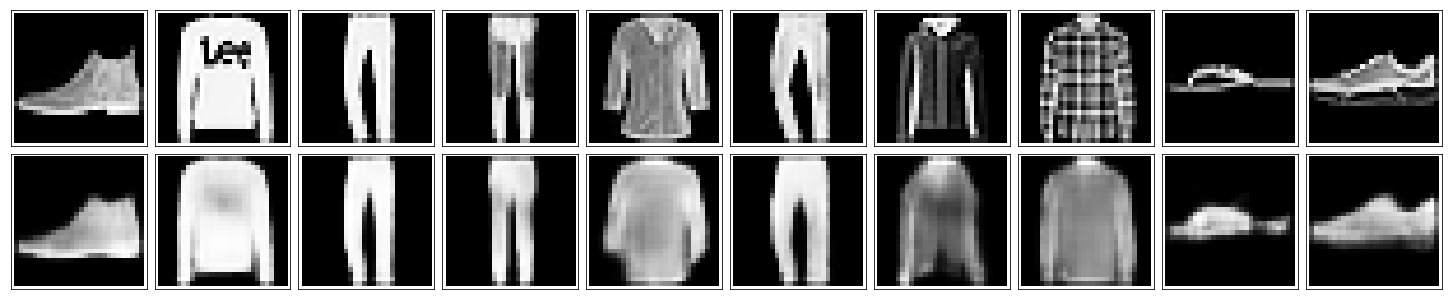

In [13]:
# Run and Save the Trained Model
with tf.Session() as sess:
    sess.run(init)
    
    # Save Current Session Graph
    writer = tf.summary.FileWriter('./output', sess.graph)
    
    # Number of Epochs to run for
    epochs= 20
    # Batch Size: Number of Images in each batch of Input Data
    batch_size = 200
    # Number of Batches
    n_batches = fashion_mnist.train.num_examples // batch_size
    
    for i in range(epochs):
        for j in range(n_batches):
            # Next Batch of Data
            batch = fashion_mnist.train.next_batch(batch_size)
            # Load Images
            img = batch[0].reshape((-1,28,28,1))
            # Run the Optimizer and Cost Functions
            result, loss_val = sess.run([optimizer, cost], feed_dict={input_image: img, target_image: img})
            
            print("Epoch: {}/{}\t".format(i,epochs),"Training Loss: {:.4f}".format(loss_val))
        
        # Plot Data from Decoder Output after every 5 Epochs
        if i % 5 == 0:
            decoder_out = sess.run(decoded_image, feed_dict={input_image: test_images.reshape((10, 28, 28, 1))})
            plot_images(decoder_out)
    
    decoder_out = sess.run(decoded_image, feed_dict={input_image: test_images.reshape((10, 28, 28, 1))})
    plot_images(decoder_out)
    
    writer.close()
    
    # Save Trained Model
    save_model.save(sess,'./trained_model/')